In [40]:
# General imports and widgets
import os
if os.getcwd().split('/')[-1] != 'deepARTransit':
    os.chdir('../..')
import sys
import warnings
import numpy as np
import matplotlib.pylab as plt
from pixlc import plotting
import ipywidgets as widgets

plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['font.size'] = 15
warnings.simplefilter("ignore")

# Project dir selection widget

project_button = widgets.Dropdown(
    options=[os.path.join('.'), # local git repo
             os.path.join('/','Users','Mario','mount_test','deepARTransit') # cobweb         
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

# Experiment selection widget

experiment_button = widgets.Dropdown(
    options=[os.path.join('deeparsys_fulltime'),
             os.path.join('cobweb', 'deeparsys_fulltime'),
             os.path.join('cobweb', 'deepartrans_fulltime'), 
             os.path.join('cobweb', 'rlc', 'deeparsys_nocov'),
             os.path.join('cobweb', 'rlc', 'deeparsys_cent'),
             os.path.join('cobweb', 'rlc', 'deeparsys_cent_2'),
             os.path.join('cobweb', 'rlc','deeparsys_pix'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_pix'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_24537600'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_22808832'),
             os.path.join('cobweb', 'rlc','deeparsys_cent_27773440'),
],
    #value=experiment_folder,
    # rows=10,
    description='\t\t',
    disabled=False
)

## Select a project directory for loading the data

In [41]:
project_button

Dropdown(description='\t\t', options=('.', '/Users/Mario/mount_test/deepARTransit'), value='.')

## Select an experiment

In [42]:
experiment_button

Dropdown(description='\t\t', options=('deeparsys_fulltime', 'cobweb/deeparsys_fulltime', 'cobweb/deepartrans_f…

In [44]:

# Loading the data
from utils.config import get_config_file, process_config
from deepartransit.data_handling import data_generator

experiment_folder = experiment_button.value
project_dir = project_button.value
experiment_dir = os.path.join(project_dir, 'deepartransit', 'experiments', experiment_folder)
print(experiment_dir)
config_file = get_config_file(experiment_dir)
config = process_config(config_file)
print('Data and covariates shapes:')
data = data_generator.DataGenerator(config)
width = int(np.sqrt(data.Z.shape[-1]))

traces_array = np.load(os.path.join(project_dir, config.output_dir, 'pred_array.npy')) #pred_array.npy
pred_instr = traces_array.mean(axis=(0))
length_pred = pred_instr.shape[1]
plc_trans = data.Z[:, config.pretrans_length:config.pretrans_length+config.trans_length+1]

./deepartransit/experiments/deeparsys_fulltime
Data and covariates shapes:
loading data from deepartransit/data_handling/plc_22807808_T.npy
(1, 690, 25) (1, 690, 2)
time_path parameter not found in config. Default to 0,1,2....T-1


FileNotFoundError: [Errno 2] No such file or directory: './deepartransit/experiments/deeparsys_fulltime/output/pred_array.npy'

## NN prediction = interpolation traces 

In [39]:
traces_array.shape

(690, 1, 25)

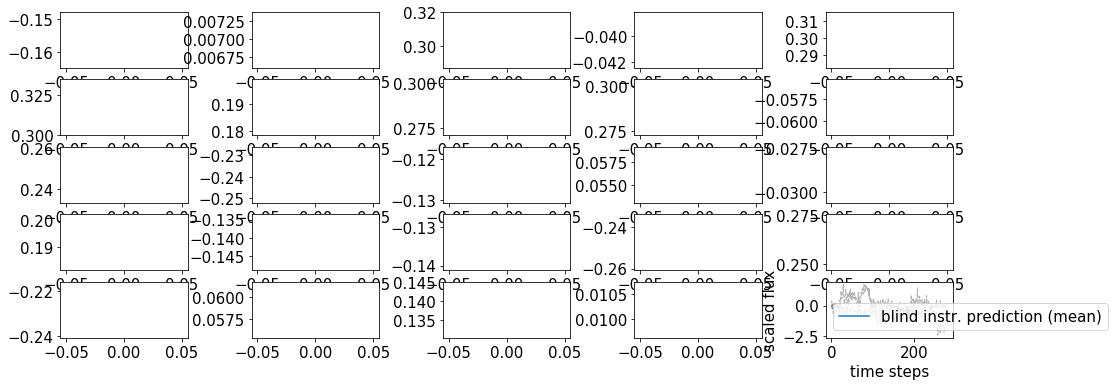

In [35]:
#grid = plotting.plot_mozaic(plc_trans.reshape(-1, width, width), label='scaled data')
#for trace in range(len(traces_array)):
#    plotting.plot_mozaic(np.expand_dims(traces_array[trace].T.reshape(-1, width, width), -1), 
#                         grid=grid, color='grey', linestyle='dashed', linewidth=1, alpha=0.3)
plotting.plot_mozaic(pred_instr.reshape(-1, width, width), grid=grid, label='blind instr. prediction (mean)')
plt.plot(data.X[0, config.pretrans_length:config.pretrans_length+config.trans_length+1],
        color='black', linestyle='dashed', linewidth=1, alpha=0.3)
plt.xlabel('time steps')
plt.ylabel('scaled flux')
plt.legend()

## Errors

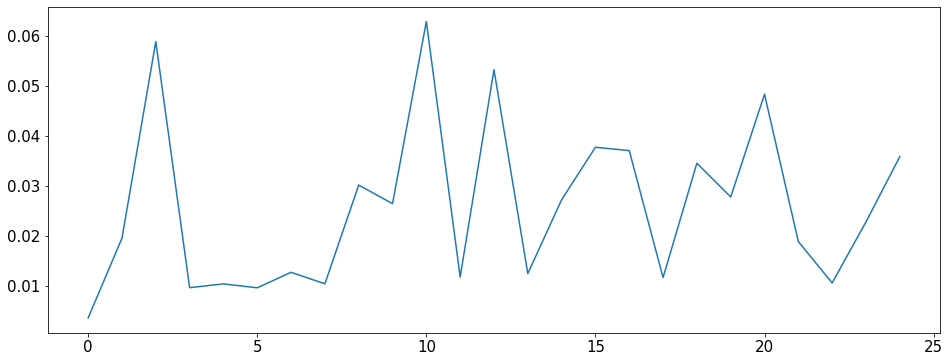

In [15]:
plt.plot(traces_array.std(axis=0).flatten())

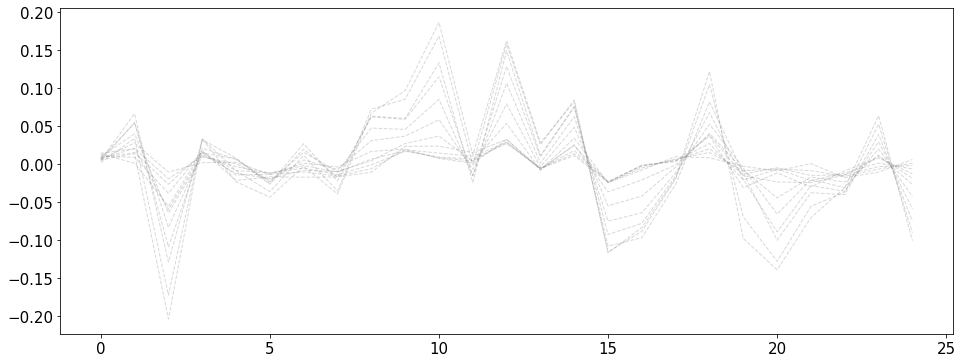

In [16]:
for trace in range(len(traces_array)):
    plotting.plot_mozaic(np.expand_dims(traces_array[trace].T.reshape(-1, width, width), -1), 
                         grid=grid, color='grey', linestyle='dashed', linewidth=1, alpha=0.3)

## Back to Original units

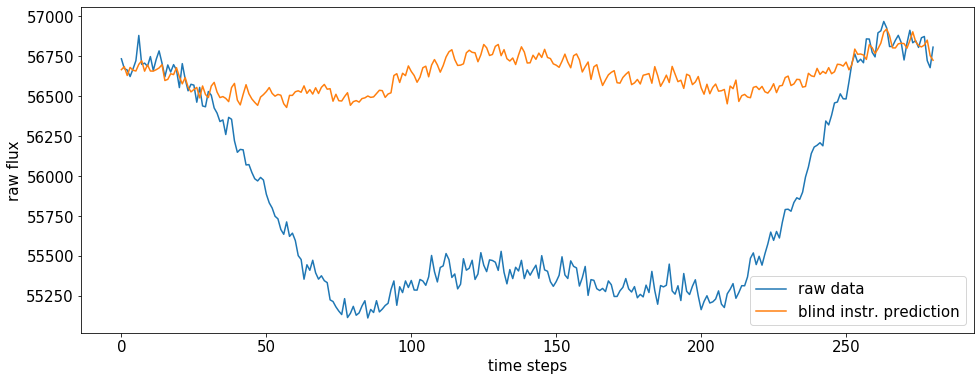

In [44]:
# Back to original scales
plc_trans = data.scaler_Z.inverse_transform(plc_trans)
pred_instr = data.scaler_Z.inverse_transform(pred_instr)
grid = plotting.plot_mozaic(plc_trans.T.reshape(-1, width, width), grid=grid, label='raw data')
plotting.plot_mozaic(pred_instr.T.reshape(-1, width, width), grid=grid, label='blind instr. prediction')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

## Extracting the transit Component

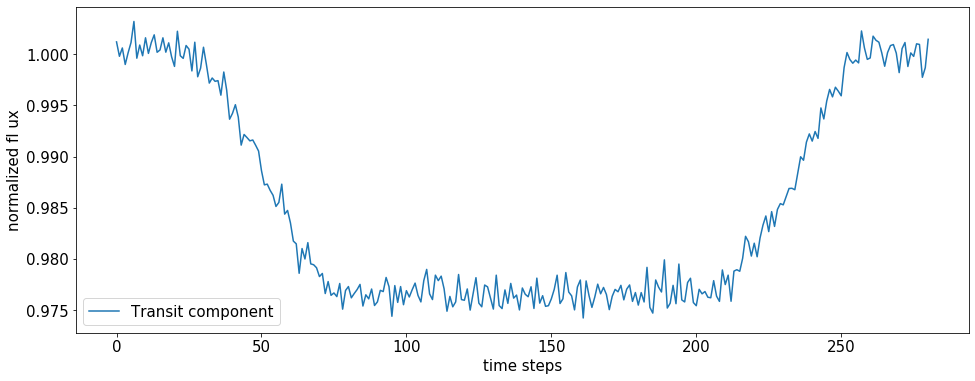

In [45]:
transit_component = (plc_trans/pred_instr)
plotting.plot_mozaic(transit_component.T.reshape(-1, width, width), label='Transit component')
plt.xlabel('time steps')
plt.ylabel('normalized fl ux')
plt.legend()

## Fitting a linear Transit to the transit component

In [46]:
from utils.transit import LinearTransit
time_array = np.arange(config.pretrans_length, config.pretrans_length + config.trans_length+1)
transit = LinearTransit(time_array)
transit.fit(transit_component)
#(t_c, delta, T, tau) = fit_transit_linear(transit_component, repeat = width**2, time_array=time_array)
(t_c, delta, T, tau) = transit.transit_pars
print('mid_time = {:0.5f}'.format(t_c))
print('delta = {:0.6f} (Rp/Rs = {:0.5f})'.format(delta, np.sqrt(delta)))
print('T = {:0.5f}'.format(T))
print('tau = {:0.5f}'.format(tau))

mid_time = 492.18747
delta = 0.023362 (Rp/Rs = 0.15285)
T = 182.25258
tau = 43.14158


In [47]:
# More transit params
t1 = t_c - T/2 - tau/2  # Beginning of ingress
t2 = t_c - T/2 + tau/2  # End of ingress
t3 = t_c + T/2 - tau/2  # Beginning of egress
t4 = t_c + T/2 + tau/2  # End of egress

MSE 1.2118017213327596e-06


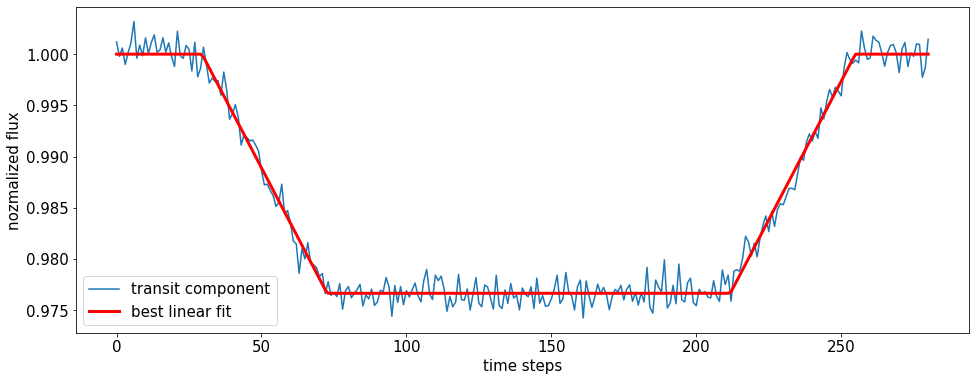

In [48]:
grid = plotting.plot_mozaic(transit_component.T.reshape(-1, width, width), label='transit component')
transit_fit_moz = np.expand_dims(transit.flux, -1).repeat(width**2, -1)
plotting.plot_mozaic(transit_fit_moz.reshape(-1,width, width), 
                     grid=grid, label='best linear fit', color='red', linewidth=3)
print('MSE',((transit_component.T - transit_fit_moz)**2).mean())
plt.xlabel('time steps')
plt.ylabel('nozmalized flux')
plt.legend()

## Back to the instrument prediction, compared to data/transit

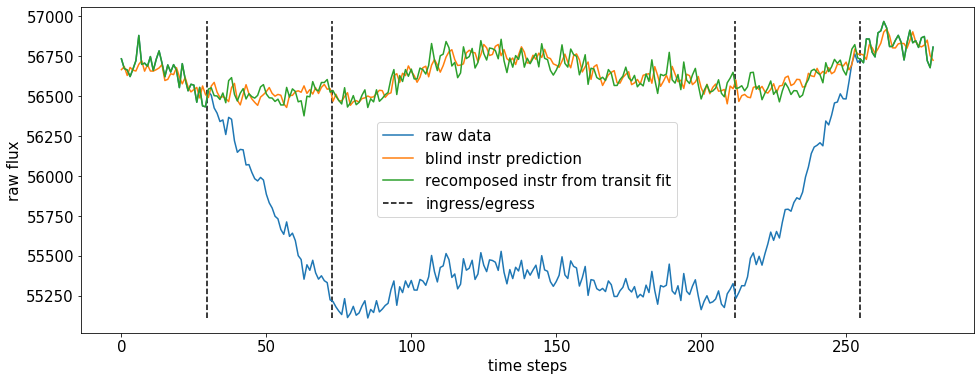

In [49]:
plt.plot(plc_trans.sum(0), label='raw data')
plt.plot(pred_instr.sum(0), label='blind instr prediction')
plt.plot(plc_trans.sum((0, -1))/transit.flux, label='recomposed instr from transit fit')
plt.vlines(t1 - config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2 - config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t3 - config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t4 - config.pretrans_length, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()

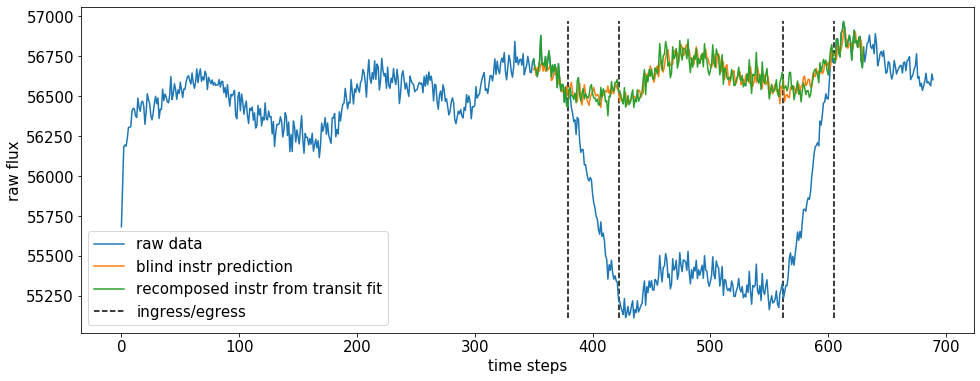

In [50]:
plt.plot(data.scaler_Z.inverse_transform(data.Z)[0,:,0], label='raw data')

plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         pred_instr.sum(0), label='blind instr prediction')
plt.plot(range(config.pretrans_length, config.pretrans_length+ config.trans_length + 1), 
         plc_trans.sum((0, -1))/transit.flux, label='recomposed instr from transit fit')
plt.vlines(t1, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed', label = 'ingress/egress')
plt.vlines(t2, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t3, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.vlines(t4, plc_trans.sum(0).min(), plc_trans.sum(0).max(), linestyle='dashed')
plt.xlabel('time steps')
plt.ylabel('raw flux')
plt.legend()
plt.show()
# covariates
# plt.plot(data.scaler_X.inverse_transform(data.X)[0,:,:], label='raw data')
